# Problema 3
Descripción:
En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


## Dataset:
https://drive.google.com/file/d/1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ/view?usp=drive_link

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

- buildings
- forest
- glacier
- mountain
- sea
- street

Las imágenes están divididas en tres conjuntos:

- Train: Alrededor de 14,000 imágenes para entrenamiento.
- Test: Alrededor de 3,000 imágenes para evaluación del modelo.
- Prediction: Alrededor de 7,000 imágenes para predicción final.

## Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas anteriormente.
Los modelos a diseñar son:

- Modelo con capas densas.
- Modelo con capas convolucionales y densas.
- Modelo que incluya bloques residuales identidad
- Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


## Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:

- Análisis previo y preprocesamiento del set de datos.
- Definición y entrenamiento del modelo.
- Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


## Librerias

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from pathlib import Path
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2


## Carga del dataset

In [2]:
# Directorio de los datos
directory = os.getcwd()
TRAIN_DATA_DIRECTORY = str(Path(f'{directory}/seg_train/seg_train'))
VALIDATION_DATA_DIRECTORY = str(Path(f'{directory}/seg_test/seg_test'))

# Tamaño del lote (batch size)
BATCH_SIZE = 32
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [3]:
dir = './seg_train/seg_train'
labels = os.listdir(dir)
cant_imgs = []

for label in labels:
    cant_imgs.append(len(os.listdir(f'{dir}/{label}')))

print(cant_imgs)

[2191, 2271, 2404, 2512, 2274, 2382]


In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Modelo denso

In [13]:
def build_model(input_shape):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(6)(x)
    output = Activation('softmax')(x)

    return tf.keras.Model(inputs=i, outputs=output)

In [14]:
print("Building model")
dense_model = build_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

dense_model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [15]:
dense_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_4 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_5 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,652,934 (33.01 MB)

 Trainable params: 8,652,934 (33.01 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
early_stopping = EarlyStopping(monitor="val_loss", patience=8, verbose=0, mode="min", restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=7, verbose=1, min_delta=1e-4, mode="min"
)

In [17]:
history = dense_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=8,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 97s 215ms/step - accuracy: 0.2241 - loss: 4.1459 - val_accuracy: 0.2317 - val_loss: 1.7165 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 128ms/step - accuracy: 0.2509 - loss: 1.6935 - val_accuracy: 0.2730 - val_loss: 1.6255 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.2439 - loss: 1.6912 - val_accuracy: 0.2600 - val_loss: 1.6580 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 55s 125ms/step - accuracy: 0.2658 - loss: 1.6506 - val_accuracy: 0.3000 - val_loss: 1.5965 - learning_rate: 0.0010
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 127ms/step - accuracy: 0.2859 - loss: 1.6473 - val_accuracy: 0.2500 - val_loss: 1.6757 - learning_rate: 0.0010
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 129ms/step - accuracy: 0.2754 - loss: 1.6482 - val_accuracy: 0.2943 - val_loss: 1.5910 - learning_rate: 0.0010
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 57s 129ms/step - accuracy: 0.2

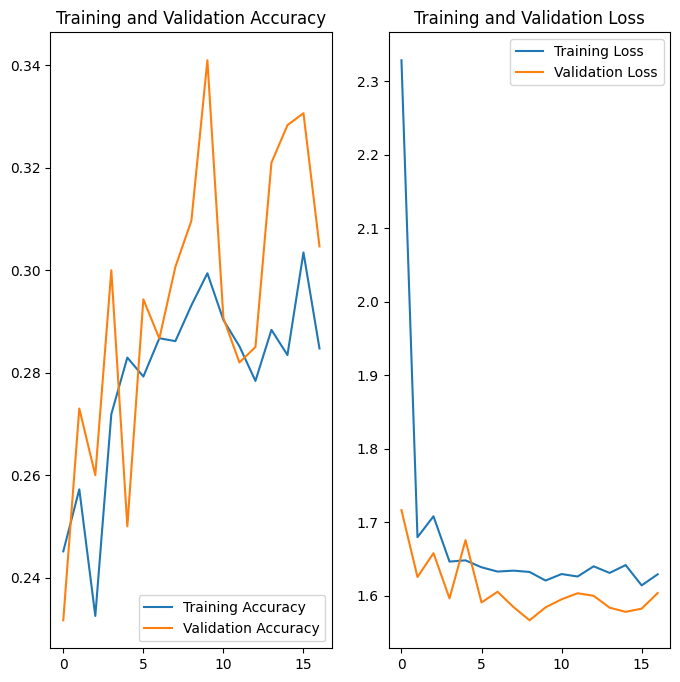

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Modelo convolucional

In [ ]:
def build_model_conv(input_shape):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D()


    x = Flatten()(x)
    x = Dense(32)(x)
    x = Activation('relu')(x)
    x = Dropout(0.1)(x)

    x = Dense(6)(x)
    output = Activation('softmax')(x)

    return tf.keras.Model(inputs=i, outputs=output)